In [16]:
import os
import numpy as np
import datetime

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib

## PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

## Torchvision
from torchvision import datasets, transforms

import pytorch_lightning as pl
import wandb
from pytorch_lightning.loggers import WandbLogger

from scipy.optimize import linear_sum_assignment
from scipy.sparse import coo_matrix

import random
import gzip
import shutil
from scipy.ndimage import shift

torch.set_float32_matmul_precision('medium')
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


In [17]:
h = {  # hyperparameters
    'model': 'SinkhornConvNet',  # 'SinkhornConvNetV2' or 'SinkhornConvNet'
    'dataset': 'MNIST', #'MNIST_SHIFT',  #'MNIST',
    'in_channels': 1,
    'num_pieces': 8,
    'image_size': 28,
    'hidden_channels': 32,
    'kernel_size': 5,
    'tau': 0.1,
    'n_sink_iter': 20,
    'epochs': 20,
    'learning_rate': 1e-4,
    'checkpoint_path': './saved_models',
    'dataset_path': '../data',
    'batch_size': 1024,
    'dataset_percent': 1.0  # 1.0 is full dataset
}
train = True  # Set this to false if you only want to evaluate the model
use_wandb = True

In [18]:
def log_sinkhorn(log_alpha, n_iter):
    """Performs incomplete Sinkhorn normalization to log_alpha.
    By a theorem by Sinkhorn and Knopp [1], a sufficiently well-behaved  matrix
    with positive entries can be turned into a doubly-stochastic matrix
    (i.e. its rows and columns add up to one) via the successive row and column
    normalization.

    [1] Sinkhorn, Richard and Knopp, Paul.
    Concerning nonnegative matrices and doubly stochastic
    matrices. Pacific Journal of Mathematics, 1967
    Args:
      log_alpha: 2D tensor (a matrix of shape [N, N])
        or 3D tensor (a batch of matrices of shape = [batch_size, N, N])
      n_iters: number of sinkhorn iterations (in practice, as little as 20
        iterations are needed to achieve decent convergence for N~100)
    Returns:
      A 3D tensor of close-to-doubly-stochastic matrices (2D tensors are
        converted to 3D tensors with batch_size equals to 1)
    """
    for _ in range(n_iter):
        log_alpha = log_alpha - torch.logsumexp(log_alpha, -1, keepdim=True)
        log_alpha = log_alpha - torch.logsumexp(log_alpha, -2, keepdim=True)
    return log_alpha.exp()


def matching(alpha):
    # Negate the probability matrix to serve as cost matrix. This function
    # yields two lists, the row and colum indices for all entries in the
    # permutation matrix we should set to 1.
    row, col = linear_sum_assignment(-alpha)

    # Create the permutation matrix.
    permutation_matrix = coo_matrix((np.ones_like(row), (row, col))).toarray()
    return torch.from_numpy(permutation_matrix)


def sample_gumbel(shape, device='cpu', eps=1e-20):
    """Samples arbitrary-shaped standard gumbel variables.
    Args:
      shape: list of integers
      eps: float, for numerical stability
    Returns:
      A sample of standard Gumbel random variables
    """
    u = torch.rand(shape, device=device)
    return -torch.log(-torch.log(u + eps) + eps)


def gumbel_sinkhorn(log_alpha, tau, n_iter):
    """ Sample a permutation matrix from the Gumbel-Sinkhorn distribution
    with parameters given by log_alpha and temperature tau.

    Args:
      log_alpha: Logarithm of assignment probabilities. In our case this is
        of dimensionality [num_pieces, num_pieces].
      tau: Temperature parameter, the lower the value for tau the more closely
        we follow a categorical sampling.
    """
    # Sample Gumbel noise.
    gumbel_noise = sample_gumbel(log_alpha.shape, device=log_alpha.device)

    # Apply the Sinkhorn operator!
    sampled_perm_mat = log_sinkhorn((log_alpha + gumbel_noise) / tau, n_iter)
    return sampled_perm_mat

In [19]:
def chunk_image(image: torch.Tensor, num_pieces: int):
    """Randomly chunk a single image.
    Args:
      image: Image [channels, height, width].

    Returns:
      pieces: Image chunks in their original positions. [num_pieces, channels,
        height // num_pieces, width // num_pieces]
      random_pieces: Image chunks in their randomly permuted positions.
      permute_index: List of permuted indices.
    """
    # Get image dimensions.
    height, width = image.shape[-2:]

    # Get piece dimensions.
    piece_height = height // num_pieces
    piece_width = width // num_pieces
    pieces = []

    # Obtain indices for each of the image chunks.
    for p_h in range(num_pieces):
        for p_w in range(num_pieces):
            left = p_w * piece_width
            right = left + piece_width
            top = p_h * piece_height
            bottom = top + piece_height
            piece = image[:, top:bottom, left:right]
            pieces.append(piece)

    pieces = torch.stack(pieces, 0)

    # Randomly permute the index of the pieces.
    permute_index = torch.randperm(num_pieces ** 2)
    random_pieces = pieces[permute_index]
    return pieces, random_pieces, permute_index


def batch_chunk_image(images: torch.Tensor, num_pieces: int):
    """Randomly chunk a batch of images.
    Args:
      image: Images [batch, channels, height, width].

    Returns:
      pieces: Batch of image chunks in their original positions. [batch,
        num_pieces, channels, height // num_pieces, width // num_pieces]
      random_pieces: Batch of image chunks in their randomly permuted positions.
         [batch, num_pieces, channels, height // num_pieces, width // num_pieces]
      permute_index: Batch of permutation lists. [batch, num_pieces**2]
    """
    batch_pieces, batch_random_pieces, batch_permute_index = [], [], []
    for image in images:
        pieces, random_pieces, permute_index = chunk_image(image, num_pieces)

        batch_pieces.append(pieces)
        batch_random_pieces.append(random_pieces)
        batch_permute_index.append(permute_index)
    return torch.stack(batch_pieces, 0), torch.stack(batch_random_pieces, 0), torch.stack(batch_permute_index, 0)


def inverse_permutation_for_image(X, permutation_matrix):
    # temp, make `permutation_matrix` transposed
    # permutation_matrix = permutation_matrix.transpose(1, 2)

    """Apply the inverse of a permutation (its transpose) to a batch of image
       chunks.
    Args:
      X: Batched sets of image chunks. [batch, num_pieces, channels, height, width]
      permutation_matrix: float, for numerical stability

    Returns:
      Permuted set of image chunks.
    """
    return torch.einsum("bpq,bpchw->bqchw", (permutation_matrix, X)).contiguous()


# Example of `inverse_permutation_for_image`
X = torch.rand((64, 4, 1, 14, 14))
permutation_matrix = torch.rand((64, 4, 4))
first1 = inverse_permutation_for_image(X, permutation_matrix)[0]  # (4, 1, 14, 14)
first1 = first1.flatten()  # (1, 784)

X_first = X[0]  # (4, 1, 14, 14)
X_first = X_first.flatten(start_dim=1)  # (4, 196)

permutation_matrix_first = permutation_matrix[0]  # (4, 4)
permutation_matrix_first = permutation_matrix_first.T  # (4, 4)
X_first_permuted = torch.mm(permutation_matrix_first, X_first)  # (4, 196)

X_first_permuted = X_first_permuted.reshape(4, 1, 14, 14)  # (4, 1, 14, 14)
X_first_permuted = X_first_permuted.flatten()  # (1, 784)

# e.g.: P^T*X = \tilde{X}, with row(X) = all pixels of a single piece
torch.allclose(first1, X_first_permuted)

True

In [20]:
class Network(pl.LightningModule):
    def training_step(self, batch, batch_idx):
        inputs, _ = batch
        pieces, random_pieces, _ = batch_chunk_image(inputs, self.num_pieces)
        pieces, random_pieces = pieces.to(self.device), random_pieces.to(self.device)
        ordered_pieces, _ = self(random_pieces)
        loss = torch.nn.functional.mse_loss(ordered_pieces, pieces, reduction='sum')
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, _ = batch
        pieces, random_pieces, _ = batch_chunk_image(inputs, self.num_pieces)
        pieces, random_pieces = pieces.to(self.device), random_pieces.to(self.device)
        ordered_pieces, _ = self(random_pieces)
        loss = torch.nn.functional.mse_loss(ordered_pieces, pieces, reduction='sum')
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4, eps=1e-8)

In [21]:
class SinkhornConvNetV1(Network):
    def __init__(self, in_channels, num_pieces, image_size, hidden_channels, kernel_size, tau=1.0, n_sink_iter=20):
        super().__init__()

        # store these for later use.
        self.tau = tau
        self.n_sink_iter = n_sink_iter
        self.num_pieces = num_pieces

        self.g_1 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size, padding=kernel_size // 2),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.BatchNorm2d(hidden_channels)
        )

        # calculate the size of a single piece in pixels
        piece_size = image_size // num_pieces

        # calculate the size of a single piece in pixels after 1 max pooling
        piece_size_after_conv = (piece_size) // (2 * 1)

        self.g_2 = nn.Linear(piece_size_after_conv ** 2 * hidden_channels, num_pieces ** 2, bias=False)

    def forward(self, batch_pieces):
        # in: (64, 4, 1, 14, 14): 4 pieces of 14x14 images
        # out: (64, 4, 1, 14, 14), (64, 4, 4): 4 pieces of 14x14 images and permutation matrices
        batch_size = batch_pieces.shape[0]

        # Switch batch and piece dimensions. We want to apply the same network to each of the pieces.
        pieces = batch_pieces.transpose(0, 1).contiguous()  # (4, 64, 1, 14, 14)

        # Apply g_1 to each of the pieces.
        conv_pieces = []
        for piece in pieces:
            piece = self.g_1(piece)
            conv_piece = piece.reshape(batch_size, -1)
            conv_pieces.append(conv_piece)

        # Apply g_2 to each of the pieces.
        latent_pieces = []
        for piece in conv_pieces:
            latent_piece = self.g_2(piece)
            latent_pieces.append(latent_piece)

        # Create a matrix of log unnormalized assignment probabilities. After this
        # the batch dimension is batch in the first position.
        log_alphas = torch.stack(latent_pieces, 1)  # (64, 4, 4)

        # During training, we sample from the Gumbel-Sinkhorn distribution.
        if self.training:
            permutation_matrices = gumbel_sinkhorn(log_alphas, tau=self.tau, n_iter=self.n_sink_iter)

        # During eval, we solve the linear assignment problem.
        else:
            permutation_matrices = torch.stack([
                matching(log_alpha)
                for log_alpha in log_alphas.cpu().detach().numpy()]
            ).float().to(log_alphas.device)

        # We obtain the ordered pieces as predicted by our network
        ordered_pieces = inverse_permutation_for_image(batch_pieces, permutation_matrices)

        # Return the ordered pieces, along with the predicted permutation.
        # We will inspect the predicted permutation matrices during test time.
        return ordered_pieces, permutation_matrices

In [22]:
class SinkhornConvNetV2(Network):
    def __init__(self, in_channels, num_pieces, image_size, hidden_channels, kernel_size, tau=1.0, n_sink_iter=20):
        super().__init__()
        self.tau = tau
        self.n_sink_iter = n_sink_iter
        self.num_pieces = num_pieces  # altough we say 2, there are 4 pieces.

        self.g_1 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size, padding=kernel_size // 2),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.BatchNorm2d(hidden_channels)
        )

        piece_size = image_size // num_pieces
        piece_size_after_conv = (piece_size) // (2 * 1)

        # out: a row of the permutation matrix (4), for each piece. --> Perm matrix will be 4x4
        self.g_2 = nn.Linear(piece_size_after_conv ** 2 * hidden_channels, (num_pieces ** 2) ** 2,
                             bias=False)  # changed to 16 pieces

    def forward(self, batch_pieces):
        # in: (64, 4, 1, 14, 14): 4 pieces of 14x14 images
        # out: (64, 4, 1, 14, 14), (64, 4, 4): 4 pieces of 14x14 images and permutation matrices
        batch_size = batch_pieces.shape[0]

        # Switch batch and piece dimensions. We want to apply the same network to each of the pieces.
        pieces = batch_pieces.transpose(0, 1).contiguous()  # (4, 64, 1, 14, 14)

        # Apply g_1 to each of the pieces.
        conv_pieces = []
        for piece in pieces:
            piece = self.g_1(piece)
            conv_piece = piece.reshape(batch_size, -1)
            conv_pieces.append(conv_piece)

        # Apply g_2 to each of the pieces.
        latent_pieces = []
        for piece in conv_pieces:
            latent_piece = self.g_2(piece).reshape(batch_size, self.num_pieces ** 2, self.num_pieces ** 2)
            latent_pieces.append(latent_piece)

        # Instead of stacking, just sum the latent pieces
        log_alphas = torch.sum(torch.stack(latent_pieces, 1), 1)  # (64, 4, 4)

        # Create a matrix of log unnormalized assignment probabilities. After this
        # the batch dimension is batch in the first position.
        # log_alphas = torch.stack(latent_pieces, 1)  # (64, 4, 4)

        # During training, we sample from the Gumbel-Sinkhorn distribution.
        if self.training:
            permutation_matrices = gumbel_sinkhorn(log_alphas, tau=self.tau, n_iter=self.n_sink_iter)

        # During eval, we solve the linear assignment problem.
        else:
            permutation_matrices = torch.stack([
                matching(log_alpha)
                for log_alpha in log_alphas.cpu().detach().numpy()]
            ).float().to(log_alphas.device)

        # We obtain the ordered pieces as predicted by our network
        ordered_pieces = inverse_permutation_for_image(batch_pieces, permutation_matrices)

        # Return the ordered pieces, along with the predicted permutation.
        # We will inspect the predicted permutation matrices during test time.
        return ordered_pieces, permutation_matrices

In [23]:
if h['model'] == 'SinkhornConvNet':
    SinkhornConvNet = SinkhornConvNetV1
elif h['model'] == 'SinkhornConvNetV2':
    SinkhornConvNet = SinkhornConvNetV2
else:
    raise ValueError(f"Unknown model: {h['model']}")

In [24]:
# # Example usage
model = SinkhornConvNet(
    in_channels=1, num_pieces=2, image_size=28, hidden_channels=32, kernel_size=5, tau=0.1, n_sink_iter=20)

random_pieces = torch.rand((64, 4, 1, 14, 14))
res1, res2 = model(random_pieces)
res1.shape, res2.shape

(torch.Size([64, 4, 1, 14, 14]), torch.Size([64, 4, 4]))

In [25]:
class MNIST_SHIFT(datasets.MNIST):
    # MNIST will look at dir classname
    def download(self) -> None:
        if self._check_exists():
            return
        print('Downloading MNIST_SHIFT')

        self.shift_mnist()

    def shift_mnist(self):
        # Directory for the shifted dataset
        shifted_dir = f'{self.root}/{self.__class__.__name__}/raw'
        os.makedirs(shifted_dir, exist_ok=True)

        # Define the transform and load the original MNIST dataset
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        trainset = datasets.MNIST(root=self.root, train=True, download=True, transform=transform)
        testset = datasets.MNIST(root=self.root, train=False, transform=transform)

        train_loader = DataLoader(trainset, batch_size=len(trainset), drop_last=True, shuffle=False)
        test_loader = DataLoader(testset, batch_size=len(testset), drop_last=False, shuffle=False)

        # Create the shifted training and test datasets
        MNIST_SHIFT.create_shifted_dataset(
            train_loader,
            os.path.join(shifted_dir, 'train-images-idx3-ubyte'),
            os.path.join(shifted_dir, 'train-labels-idx1-ubyte'))
        MNIST_SHIFT.create_shifted_dataset(
            test_loader,
            os.path.join(shifted_dir, 't10k-images-idx3-ubyte'),
            os.path.join(shifted_dir, 't10k-labels-idx1-ubyte'))

        MNIST_SHIFT.compress_file(os.path.join(shifted_dir, 'train-images-idx3-ubyte'))
        MNIST_SHIFT.compress_file(os.path.join(shifted_dir, 'train-labels-idx1-ubyte'))
        MNIST_SHIFT.compress_file(os.path.join(shifted_dir, 't10k-images-idx3-ubyte'))
        MNIST_SHIFT.compress_file(os.path.join(shifted_dir, 't10k-labels-idx1-ubyte'))

    @staticmethod
    def shift_image(image, shift_x, shift_y):
        image_np = image.numpy()
        shifted_image = shift(image_np, [shift_y, shift_x], mode='constant', cval=0)
        return torch.tensor(shifted_image)

    @staticmethod
    def create_shifted_dataset(loader, output_images_file, output_labels_file):
        images = []
        labels = []
        max_shift = 28 // 3  # = 9

        for data, target in loader:
            for i in range(data.shape[0]):
                shift_x = random.randint(-max_shift, max_shift)
                shift_y = random.randint(-max_shift, max_shift)
                shifted_img = MNIST_SHIFT.shift_image(data[i, 0], shift_x, shift_y)
                temp = shifted_img.numpy().reshape(28, 28)
                # Scale the image back to the range [0, 255]
                temp = temp * 255
                images.append(temp.flatten())
                labels.append(target[i].item())

        images = np.array(images, dtype=np.uint8)
        labels = np.array(labels, dtype=np.uint8)

        # Save the images
        with open(output_images_file, 'wb') as img_file:
            img_file.write(b'\x00\x00\x08\x03')
            img_file.write(len(images).to_bytes(4, byteorder='big'))
            img_file.write((28).to_bytes(4, byteorder='big'))
            img_file.write((28).to_bytes(4, byteorder='big'))
            img_file.write(images.tobytes())

        # Save the labels
        with open(output_labels_file, 'wb') as lbl_file:
            lbl_file.write(b'\x00\x00\x08\x01')
            lbl_file.write(len(labels).to_bytes(4, byteorder='big'))
            lbl_file.write(labels.tobytes())

    @staticmethod
    def compress_file(file_path):  # Optionally, compress the files 
        with open(file_path, 'rb') as f_in:
            with gzip.open(file_path + '.gz', 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

In [26]:
device = torch.device('cuda')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

if h['dataset'] == 'MNIST':
    trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
    testset = datasets.MNIST(root='../data', train=False, transform=transform)
elif h['dataset'] == 'MNIST_SHIFT':
    trainset = MNIST_SHIFT(root='../data', train=True, download=True, transform=transform)
    testset = MNIST_SHIFT(root='../data', train=False, transform=transform)
else:
    raise ValueError(f"Unknown dataset: {h['dataset']}")

train_loader = DataLoader(trainset, h['batch_size'], drop_last=True, shuffle=True, num_workers=1, persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, h['batch_size'], drop_last=False, shuffle=False)

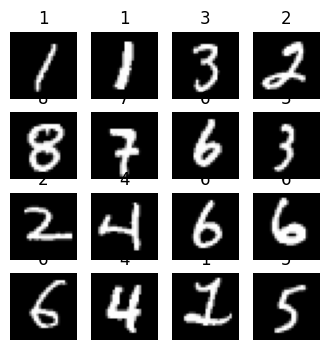

In [27]:
# Display a few images
images, labels = next(iter(train_loader))
first_img = images[0].squeeze()
fig, axs = plt.subplots(4, 4, figsize=(4, 4), sharex=True, sharey=True)
for i in range(16):
    axs[i // 4, i % 4].imshow(images[i].squeeze(), cmap='gray')
    axs[i // 4, i % 4].set_title(labels[i].item())
    axs[i // 4, i % 4].axis('off')
plt.show()

In [28]:
class CustomCallbacks(pl.Callback):
    def __init__(self, plot_every_n_epoch, num_pieces, wandb_logger: WandbLogger):
        super().__init__()
        self.plot_every_n_epoch = plot_every_n_epoch
        self.num_pieces = num_pieces
        self.wandb_logger = wandb_logger

    def assemble_image(self, pieces):
        # pieces: [num_pieces, channels, height // num_pieces, width // num_pieces]
        num_pieces, channels, piece_height, piece_width = pieces.shape
        num_pieces_side = int(num_pieces ** 0.5)

        # Reshape to [num_pieces_side, num_pieces_side, channels, piece_height, piece_width]
        pieces = pieces.view(num_pieces_side, num_pieces_side, channels, piece_height, piece_width)

        # Permute to [channels, num_pieces_side, piece_height, num_pieces_side, piece_width]
        pieces = pieces.permute(2, 0, 3, 1, 4)

        # Reshape to [channels, height, width]
        image = pieces.contiguous().view(channels, num_pieces_side * piece_height, num_pieces_side * piece_width)

        return image

    def log_images(self, trainer, pl_module, loader, prefix):
        if (trainer.current_epoch % self.plot_every_n_epoch == 0) or (trainer.current_epoch == h['epochs'] - 1):
            pl_module.eval()
            image_batch, label_batch = next(iter(loader))
            pieces, random_pieces, _ = batch_chunk_image(image_batch, self.num_pieces)
            pieces, random_pieces = pieces.to(pl_module.device), random_pieces.to(pl_module.device)

            ordered_pieces, permutation_matrices = pl_module(random_pieces)
            # Assemble the pieces into a single image before logging
            nb_ims = min(ordered_pieces.shape[0], 10)
            for i in range(nb_ims):
                initial_image = self.assemble_image(random_pieces[i])
                ordered_image = self.assemble_image(ordered_pieces[i])
                ground_truth_image = self.assemble_image(pieces[i])

                # log to wandb
                self.wandb_logger.experiment.log(
                    {f"{prefix}_predicted_image/img_{i}": wandb.Image(ordered_image.cpu().squeeze(),
                                                                      caption=f"Label {label_batch[i]}"),
                     f"{prefix}_ground_truth/img_{i}": wandb.Image(ground_truth_image.cpu().squeeze(),
                                                                   caption=f"Label {label_batch[i]}"),
                     f"{prefix}_input/img_{i}": wandb.Image(initial_image.cpu().squeeze(),
                                                            caption=f"Label {label_batch[i]}")},
                    step=trainer.global_step)

            pl_module.train()

    def on_train_epoch_end(self, trainer: pl.Trainer, pl_module: SinkhornConvNet):
        self.log_images(trainer, pl_module, train_loader, "TRAIN")

    def on_validation_epoch_end(self, trainer: pl.Trainer, pl_module: SinkhornConvNet):
        pass

    def on_train_end(self, trainer, pl_module):
        self.log_images(trainer, pl_module, test_loader, "TEST_SET_train_end")


In [29]:
# Initialize the model
model = SinkhornConvNet(in_channels=h['in_channels'],
                        num_pieces=h['num_pieces'],
                        image_size=h['image_size'],
                        hidden_channels=h['hidden_channels'],
                        kernel_size=h['kernel_size'],
                        tau=h['tau'],
                        n_sink_iter=h['n_sink_iter'])

if train:
    if use_wandb:
        date_identifier = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        wandb_logger = WandbLogger()
        wandb.init(project='sinkhorn_netw', config=h, entity='oboii',
                   name=f'{h["model"]}_{h["dataset"]}_{h["num_pieces"]}_pieces_{date_identifier}')

    trainer = pl.Trainer(
        max_epochs=h['epochs'],
        callbacks=[CustomCallbacks(plot_every_n_epoch=1, num_pieces=h['num_pieces'], wandb_logger=wandb_logger)],
        logger=wandb_logger,
        limit_train_batches=h['dataset_percent'],
        limit_val_batches=h['dataset_percent'],
        limit_test_batches=h['dataset_percent'])

    # Train the model
    trainer.fit(model, train_loader, val_dataloaders=test_loader)

    # Save the model
    torch.save(model.state_dict(), os.path.join(h['checkpoint_path'], 'model.pth'))

    # Finish the run if we it was running
    if wandb.run is not None:
        wandb.finish()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
C:\Python\Python39\lib\site-packages\pytorch_lightning\loggers\wandb.py:390: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | g_1  | Sequential | 896   
1 | g_2  | Linear     | 2.0 K 
------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total esti

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
C:\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: ERROR Control-C detected -- Run data was not synced


In [30]:
model.load_state_dict(torch.load(f"{h['checkpoint_path']}/model.pth"))

image_batch, _ = next(iter(test_loader))
pieces, random_pieces, perm_list = batch_chunk_image(image_batch, h['num_pieces'])
# pieces, random_pieces = pieces.to(device), random_pieces.to(device)

# Make sure we are evaluating!
model.eval()

# Predict the correctly ordered pieces.
predicted_pieces, _ = model(random_pieces)

# Select an image from the batch.
batch_idx = 3

# Plot the original scrambed image.
figs, axs = plt.subplots(h['num_pieces'], h['num_pieces'], figsize=(4, 4), sharex=True, sharey=True)
# remove x, y ticks
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
for idx, piece in enumerate(random_pieces[batch_idx]):
    axs[idx // h['num_pieces'], idx % h['num_pieces']].imshow(piece.cpu().squeeze())
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Plot the predicted reconstructed image.
figs, axs = plt.subplots(h['num_pieces'], h['num_pieces'], figsize=(4, 4), sharex=True, sharey=True)
# remove x, y ticks
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

for idx, piece in enumerate(predicted_pieces[batch_idx]):
    axs[idx // h['num_pieces'], idx % h['num_pieces']].imshow(piece.cpu().squeeze())
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Plot the ground truth image.
figs, axs = plt.subplots(h['num_pieces'], h['num_pieces'], figsize=(4, 4), sharex=True, sharey=True)
# remove x, y ticks
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

for idx, piece in enumerate(pieces[batch_idx]):
    axs[idx // h['num_pieces'], idx % h['num_pieces']].imshow(piece.cpu().squeeze())
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


KeyboardInterrupt: 